In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/Social-Distance-IIC

/content/drive/My Drive/Colab Notebooks/Social-Distance-IIC


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt
from helper_functions import *
import sys

## Download YOLOv3 model 

In [ ]:
# YOLO v3

# !wget "https://pjreddie.com/media/files/yolov3.weights"
# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
# !mkdir models/YOLO_v3 
# !mv yolov3.weights models/YOLO_v3/yolov3.weights
# !mv yolov3.cfg models/YOLO_v3/yolov3.cfg
# !mv coco.names models/YOLO_v3/coco.names

In [ ]:
# YOLO v3 Light (slighly lower accuracy)

# !wget "https://pjreddie.com/media/files/yolov3-tiny.weights"
# !wget "https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg"
# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
# !mkdir models/YOLO_v3_tiny 
# !mv yolov3-tiny.weights models/YOLO_v3_tiny/yolov3-tiny.weights
# !mv yolov3-tiny.cfg models/YOLO_v3_tiny/yolov3-tiny.cfg
# !mv coco.names models/YOLO_v3_tiny/coco.names

## Get video-Frame For calibration variables

In [4]:
# video_path = 'data/Student_video.mp4'
# frame_path = 'data/Student_video_frame_{}.jpg'

# frame_number = [100,200,300,400,500]

# video = cv2.VideoCapture(video_path)

# frame_count = 0
# while True:
#   ret,frame = video.read()

#   if not ret:
#     break
  
#   frame_count+=1
#   if frame_count in frame_number:
#     print("Frame number : ",frame_count, "Saved")
#     cv2.imwrite(frame_path.format(frame_count),frame)

# video.release()

## Select Image

In [5]:
original_image_BGR = cv2.imread('data/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
main_header = cv2.imread('templates/main_header.jpg')

image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


## Select Points for Perspective Transform

In [6]:
# For Select Manualy 
# source_points = get_points(original_image_BGR_copy, 4, image_size=(image_width,image_height))

# points for TownCenter.mp4 or TownCenter_frames and pedestrians.avi or pedestrians_frames
# source_points = np.float32([[ 796.,  180.],
#                             [1518.,  282.],
#                             [1080.,  719.],
#                             [ 128.,  480.]])

# points for pedestrianWalking.mp4 or pedestrianWalking_frames
# source_points = np.float32([[361., 212.],
#                             [673., 248.],
#                             [597., 338.],
#                             [265., 286.]])

# points for Student_video.mp4 or Student_video_frames
# source_points = np.float32([[ 141.,  546.],
#                            [ 695.,  449.],
#                            [1014.,  519.],
#                            [ 437.,  692.]])


# points for MOT20_02_raw.mp4 or MOT20_02_raw_frames
source_points = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])


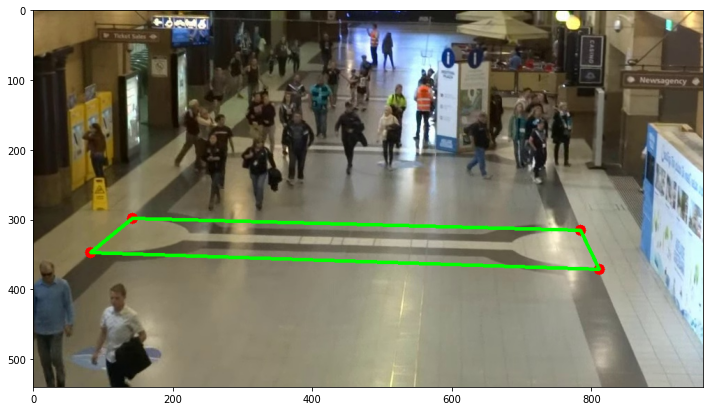

In [7]:
for point in source_points:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

## perspective transform matrix

In [8]:
src=source_points

# destination points for Towncenter.mp4 or TownCenter_frames
# dst=np.float32([(0.1,0.5), (0.69, 0.5), (0.69,0.8), (0.1,0.8)])

# destination points for  pedestrianWalking.mp4 or pedestrianWalking_frames
# dst=np.float32([(0.49,0.5), (0.77, 0.5), (0.77,0.65), (0.49,0.65)])

# destination points for  Student_video.mp4 or Student_video_frames
# dst=np.float32([(0.1,0.8), (0.37, 0.8), (0.37,0.90), (0.1,0.90)])

# destination points for  MOT20_02_raw.mp4 or MOT20_02_raw_frames
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


## Get warpPerspective Image (TOP View)

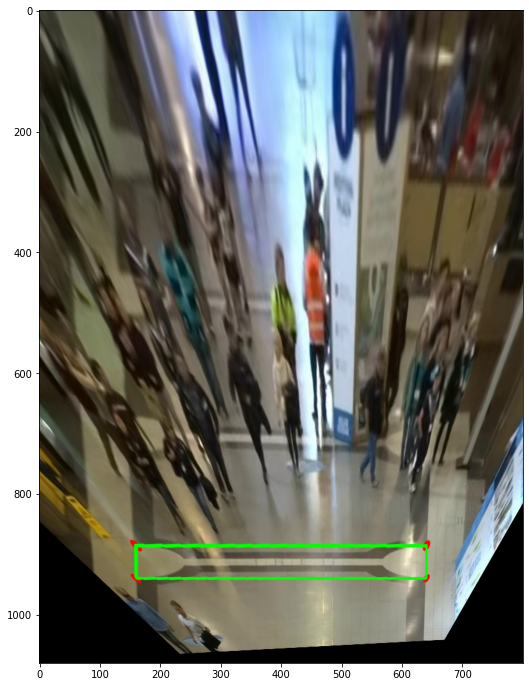

In [9]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

## Create YOLO model with weights and set parameters

In [10]:
confidence_threshold = 0.5
nms_threshold = 0.4

min_distance = 60
width = 608
height = 608

config = 'models/YOLO_v3/yolov3.cfg'
weights = 'models/YOLO_v3/yolov3.weights'
classes = 'models/YOLO_v3/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

model = create_model(config, weights)
output_layers = get_output_layers(model)

## prediction with YOLO

In [11]:
blob = blob_from_image(original_image_RGB, (width, height))
outputs = predict(blob, model, output_layers)

## Get Detected Person Boxes

In [12]:
boxes = get_image_boxes(outputs, image_width, image_height, coco_classes)

## Get Points as Birds Eye View

In [13]:
birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)

## Get Red and Green Box Cordinates

In [14]:
green_box, red_box = get_red_green_boxes(min_distance, birds_eye_points, boxes)

## Generate Birds-Eye-View Image

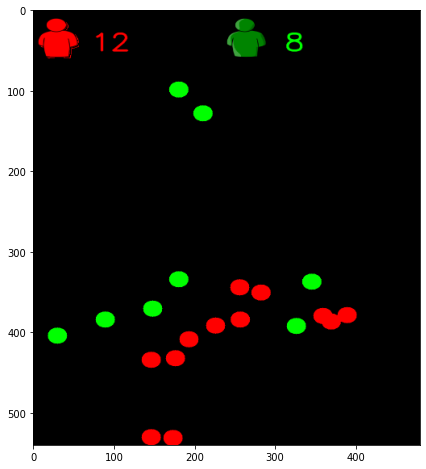

In [15]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(birds_eye_view_image, cv2.COLOR_RGB2BGR))
plt.show()

## Draw red and green boxes on detected Human

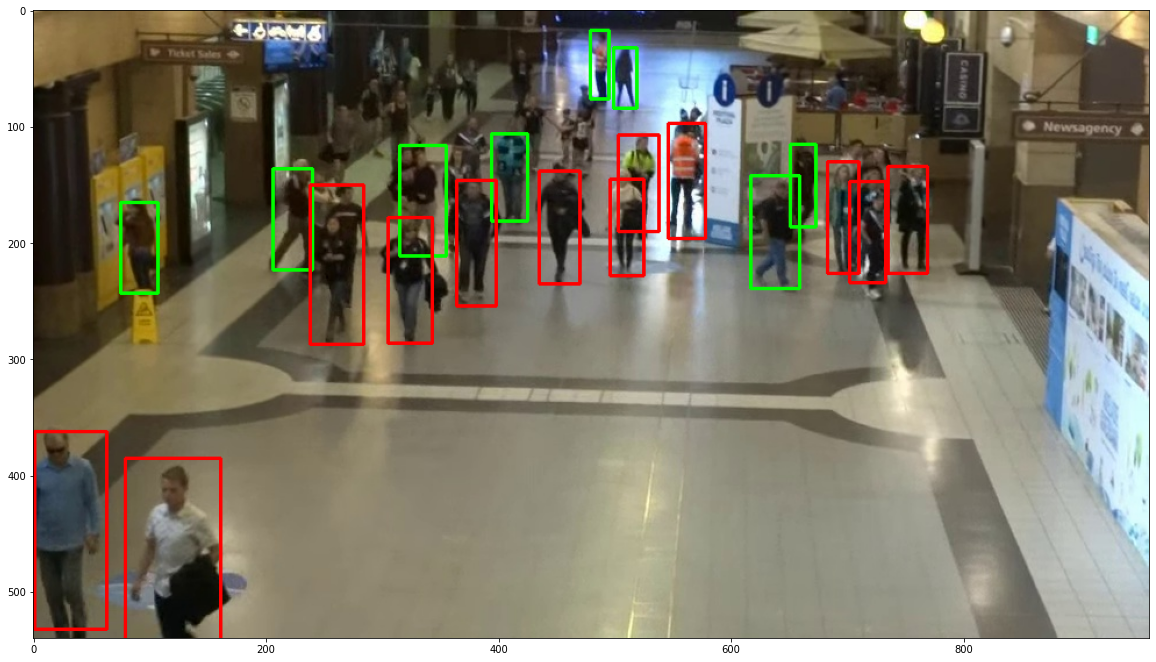

In [16]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

## Combine both image horizontally and template

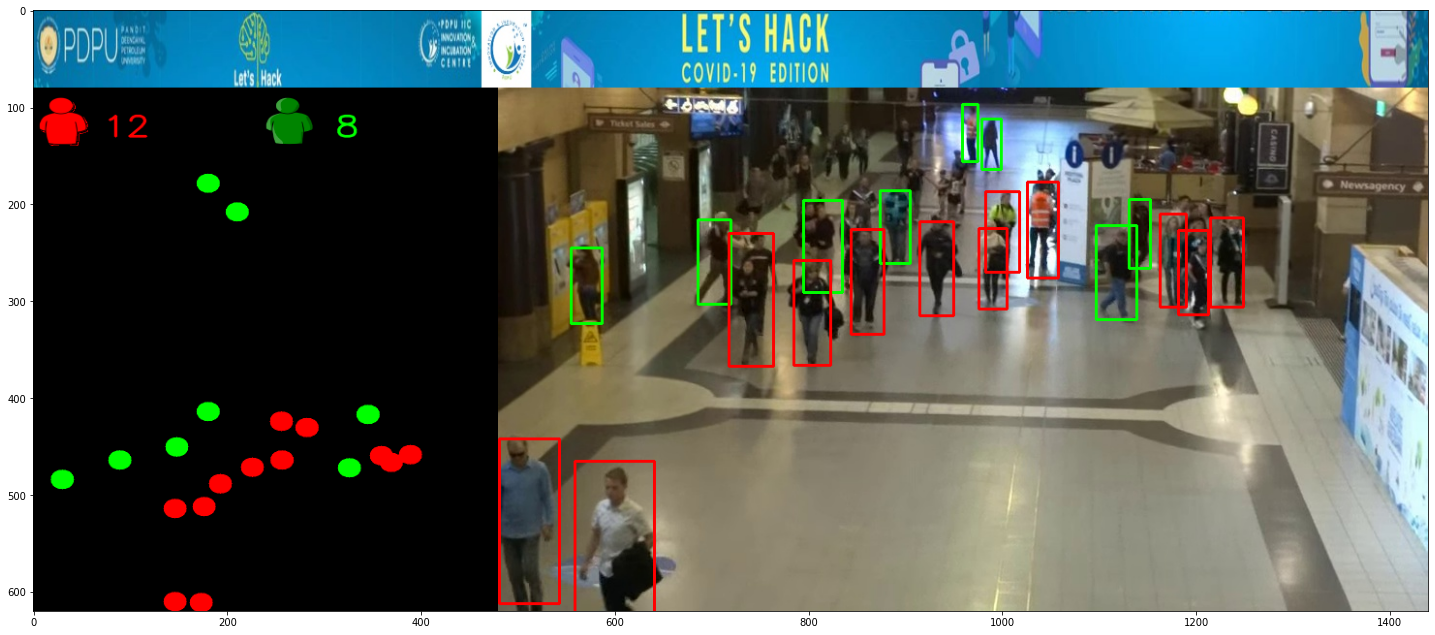

In [17]:
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
main_header = cv2.resize(main_header,(combined_image.shape[1],main_header.shape[0]))
deshboard_image  = np.concatenate((main_header,combined_image), axis=0)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(deshboard_image, cv2.COLOR_RGB2BGR))
plt.show()

## Social Distance On Video

In [ ]:
%%time

video = cv2.VideoCapture('data/MOT20-02-raw.webm')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break

  image_height, image_width = frame.shape[:2]

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  blob = blob_from_image(image, (width, height))
  outputs = predict(blob, model, output_layers)

  boxes = get_image_boxes(outputs, image_width, image_height, coco_classes)
  birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes(min_distance, birds_eye_points,boxes)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
  main_header = cv2.resize(main_header,(combined_image.shape[1],main_header.shape[0]))
  deshboard_image  = np.concatenate((main_header,combined_image), axis=0)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('result/result_15_MOT20-02-raw_1.avi', fourcc, 15, (deshboard_image.shape[1], deshboard_image.shape[0]), True)

  writer.write(deshboard_image)

  del image,outputs,combined_image,deshboard_image,birds_eye_view_image

print(' ')
writer.release()
video.release()


Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      
1                   |22                       |12                       |10                       
2                   |20                       |12                       |8                        
3                   |20                       |10                       |10                       
4                   |20                       |14                       |6                        
5                   |21                       |13                       |8                        
6                   |21                       |15                       |6                        
7                   |21                       |13                       |8                        
8                   |22                       |14                       |8                        
9                   |24                       |15                       |9                        
10        